In [1]:
from phi.torch.flow import * 
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np 
import torch.nn as nn
from torch.nn.functional import relu as relu
import time

## (1) Solver implementation

* using provided solution

In [2]:
class DifferentiableKS():
    def __init__(self, resolution, domain_size, dt):
        self.resolution = resolution
        self.domain_size = domain_size
        self.dt = dt
        self.dx = domain_size/resolution
        
        # Matrices for exp. timestepping
        self.wavenumbers = math.fftfreq(math.spatial(x=resolution), 
                                        self.dx).vector[0] * 1j
        self.L_mat = -self.wavenumbers**2-self.wavenumbers**4
        self.exp_lin = math.exp(self.L_mat * dt)
        self.nonlinear_coef_1 = math.divide_no_nan((self.exp_lin - 1)
                                                   , self.L_mat)
        self.nonlinear_coef_1 = math.where(self.nonlinear_coef_1==0, 
                                           self.dt, self.nonlinear_coef_1)
        self.nonlinear_coef_2 = math.divide_no_nan((self.exp_lin - 1 - self.L_mat*self.dt), 
                                                    (self.dt * self.L_mat**2))
        self.nonlinear_coef_2 = math.where(self.nonlinear_coef_2==0, 
                                           self.dt/2, self.nonlinear_coef_2)

    def etrk2(self, u):
        nonlin_current = self.calc_nonlinear(u)
        u_interm = self.exp_lin * math.fft(u) + nonlin_current*self.nonlinear_coef_1
        u_new  = u_interm + (self.calc_nonlinear(math.real(math.ifft(tensor(u_interm,u.shape)))) +
                 - nonlin_current) * self.nonlinear_coef_2
        return math.real(math.ifft(tensor(u_new,u.shape))) 
        
    def calc_nonlinear(self,u):
        return -0.5*self.wavenumbers*math.fft(u**2)

with math.precision(32):
    diff_ks = DifferentiableKS(resolution=50, domain_size=10, dt=1/2)


## (2) Dataset generation

In [3]:
# to make it compatible with Torch 
with math.precision(32):
    x = diff_ks.domain_size*math.tensor(np.arange(0,diff_ks.resolution),
                                        spatial('x'))/diff_ks.resolution 
    u_dataset_init = [math.cos(2*x) +0.1*math.cos(2*math.PI*x/diff_ks.domain_size)*
                      (1-2*math.sin(2*math.PI*x/diff_ks.domain_size)),
                      math.cos(2*x) +0.1*math.cos(2*math.PI*x/diff_ks.domain_size)*
                      (1-1*math.sin(2*math.PI*x/diff_ks.domain_size)),
                      math.cos(2*x) -0.1*math.cos(2*math.PI*x/diff_ks.domain_size)*
                      (1+2*math.sin(2*math.PI*x/diff_ks.domain_size)),
                      math.cos(2*x) +0.1*math.cos(2*math.PI*x/diff_ks.domain_size)*
                      (1-3*math.sin(2*math.PI*x/diff_ks.domain_size)),
                      math.cos(2*x) +0.1*math.cos(2*math.PI*x/diff_ks.domain_size)*
                      (1-8*math.sin(2*math.PI*x/diff_ks.domain_size)),
                      math.cos(2*x) -0.1*math.cos(2*math.PI*x/diff_ks.domain_size)*
                      (1+4*math.sin(2*math.PI*x/diff_ks.domain_size)),]

    u_dataset_init = [math.expand(u, batch(b=1)) for u in u_dataset_init]
    u_dataset_init = math.concat(u_dataset_init, batch('b'))

    # Exponential timestepping with RK2
    u_traj = [u_dataset_init]
    u_iter = u_dataset_init
    nonlin_iter = diff_ks.calc_nonlinear(u_dataset_init)
    for i in range(8000):
        u_iter = diff_ks.etrk2(u_iter)
        u_traj.append(u_iter)

u_traj = tensor(u_traj,instance('time') , u_iter.shape)
# np.savez('/Users/safayilmaz/Desktop/adv_dl/Exercises/adv_dl_physics/exercise-10', u_traj)


In [4]:
u_traj.shape

(bᵇ=6, timeⁱ=8001, xˢ=50)

In [5]:
class ConvResNet(nn.Module):
    '''
input ---> conv_1 ---> conv_2 ---> conv_3 ---> conv_4 ---> conv_5 ---> conv_6-->
     ^                        ^  ^                    ^  ^                    ^ 
     |                        |  |                    |  |                    | 
     |                        |  |                    |  |                    | 
     |                        |  |                    |  |                    | 
      ------------------------    --------------------    --------------------  
        Skip-Connection 1          Skip-Connection 2       Skip-Connection 3
           
--> conv_7 ---> conv_8 ---> conv_9 ---> conv_10 --> conv_11 ---> output
^                    ^  ^                    ^
|                    |  |                    | 
|                    |  |                    |
|                    |  |                    |
 --------------------    --------------------
 Skip-Connection 4        Skip-Connection 5
    '''
    def __init__(self):

        super(ConvResNet, self).__init__()
        self.relu = nn.ReLU()
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=4, 
                                kernel_size=3,stride=1, padding=1, 
                                padding_mode='circular')
        self.conv_2 = nn.Conv1d(in_channels=4, out_channels=16, 
                                kernel_size=3,stride=1, padding=1, 
                                padding_mode='circular')
        self.skip_connection_1 = nn.Conv1d(1,16, 1, 1)

        self.conv_3 = nn.Conv1d(16,32,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.conv_4 = nn.Conv1d(32,32,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.skip_connection_2 = nn.Conv1d(16, 32, 1,1)

        self.conv_5 = nn.Conv1d(32,32,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.conv_6 = nn.Conv1d(32,32,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.skip_connection_3 = nn.Conv1d(32, 32, 1, 1)

        self.conv_7 = nn.Conv1d(32,16,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.conv_8 = nn.Conv1d(16,8,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.skip_connection_4 = nn.Conv1d(32, 8, 1, 1)

        self.conv_9 = nn.Conv1d(8,8,3,stride=1, padding=1, 
                                padding_mode='circular')
        self.conv_10 = nn.Conv1d(8,4,3,stride=1, padding=1, 
                                 padding_mode='circular')
        self.skip_connection_5 = nn.Conv1d(8, 4, 1, 1)

        self.conv_11 = nn.Conv1d(4, 1, 3, stride=1, padding=1, 
                                 padding_mode='circular')
        # self.fc_layer = nn.Linear(50, 50)

    def forward(self,x):

        x1 = self.conv_1(x)
        x1 = relu(x1)
        x1 = self.conv_2(x1)
        x1 = relu(x1)
        # += does not work ? 
        x1 = x1 + self.skip_connection_1(x)

        x2 = self.conv_3(x1)
        x2 = relu(x2)
        x2 = self.conv_4(x2)
        x2 = relu(x2)
        x2 = x2 + self.skip_connection_2(x1)

        x3 = self.conv_5(x2)
        x3 = relu(x3)
        x3 = self.conv_6(x3)
        x3 = relu(x3)
        x3 = x3 + self.skip_connection_3(x2)

        x4 = self.conv_7(x3)
        x4 = relu(x4)
        x4 = self.conv_8(x4)
        x4 = relu(x4)
        x4 = x4 +  self.skip_connection_4(x3)

        x5 = self.conv_9(x4)
        x5 = relu(x5)
        x5 = self.conv_10(x5)
        x5 = relu(x5)
        x5 = x5 + self.skip_connection_5(x4)
        return self.conv_11(x5)

In [6]:
network = ConvResNet()

In [7]:
# check if network is "deep" enough
total_params = sum(param.numel() for param in network.parameters())
total_params

15293

In [8]:
u_initial = u_traj.time[0]
u_initial

(bᵇ=6, xˢ=50) 0.051 ± 0.744 (-1e+00...1e+00)

In [9]:
# u_initial = CenteredGrid(u_initial)
# u_initial
# math.native_call(network, u_traj.time[0])

In [10]:
num_time_steps = 8000
optimizer = adam(network, learning_rate=1e-3)

def loss_func(target, pred):
    loss = 0
    # print(f"target shape: {target.shape}")
    
    # prev time step 
    pred = math.native_call(network, target.time[0])
    for i in range(2):
        # print(f"shape: {target.time[i+1].shape}")
        loss += math.l2_loss( pred - target.time[i+1])
        # next time step prediction 
        pred = math.native_call(network, pred)

    # sum along batches 
    return math.sum(loss,'b')

start_time = time.time()
pred = math.native_call(network, u_traj.time[0])
for i in range(num_time_steps-4):
    loss = update_weights(network, optimizer, loss_func, 
                          u_traj.time[i:i+3], pred)
    if( i %1000==0):
        print(f'step : {i}, loss : {loss}')
end_time = time.time()
print(f"Final loss: {loss}")
print(f"total time: {end_time - start_time}")

step : 0, loss : 208.30833
step : 1000, loss : 0.058913063
step : 2000, loss : 0.037013892
step : 3000, loss : 0.024475083
step : 4000, loss : 0.03856992
step : 5000, loss : 0.02350597
step : 6000, loss : 0.017560247
step : 7000, loss : 0.017869636
Final loss: 0.02202731
total time: 73.83623790740967


* to assess the network performance we can use some sampled data and track the same loss that we have already used during training 

In [11]:
with math.precision(32):
    x = diff_ks.domain_size*math.tensor(np.arange(0,diff_ks.resolution),
                                        spatial('x'))/diff_ks.resolution 
    # use 5 ,which has not been used yet
    u_dataset_test = [math.cos(2*x) +0.1*
                      math.cos(2*math.PI*x/diff_ks.domain_size)*(
                          1-5*math.sin(2*math.PI*x/diff_ks.domain_size))]

    u_dataset_test = [math.expand(u, batch(b=1)) for u in u_dataset_test]
    u_dataset_test = math.concat(u_dataset_test, batch('b'))

    # Exponential timestepping with RK2
    u_traj = [u_dataset_test]
    u_iter = u_dataset_test
    nonlin_iter = diff_ks.calc_nonlinear(u_dataset_test)
    for i in range(800):
        u_iter = diff_ks.etrk2(u_iter)
        u_traj.append(u_iter)

u_test = tensor(u_traj,instance('time') , u_iter.shape)
u_test = u_test.b[0]
u_test

(timeⁱ=801, xˢ=50) 0.051 ± 1.310 (-3e+00...3e+00)

In [12]:
# use the network to obtain first 800 time steps to 
# make the comparision compatible 
u0 = u_test.time[0]
with torch.no_grad():
    u_pred = math.native_call(network, u0)
print(f"shape of initial point: {u_pred.shape}")
u_traj_pred = math.expand(u_pred, spatial('time'))
for _ in range(800):
    with torch.no_grad():
        # from prev step predict the next time step
        u_pred = math.native_call(network, u_pred) 
        u_traj_pred = math.concat([u_traj_pred, 
                                   math.expand(u_pred, spatial('time'))], 'time')   
u_traj_pred.shape

shape of initial point: (xˢ=50)


(timeˢ=801, xˢ=50)

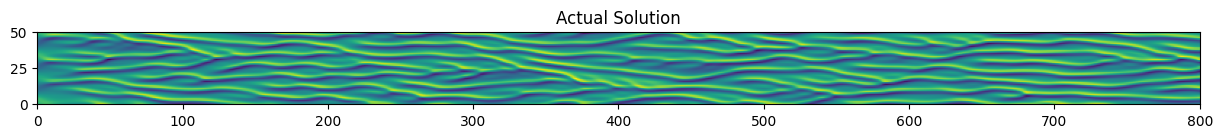

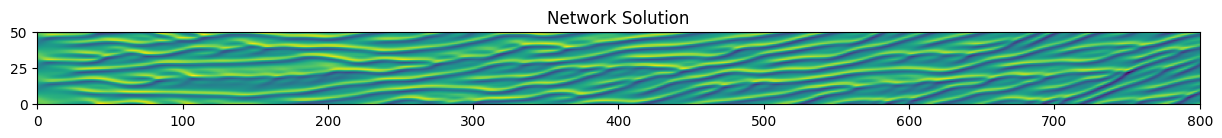

In [13]:
# extent = [left, right, bottom, top]
# actual solution 
u_test_plot = u_test.numpy(order = 'time, x')
u_pred_plot = u_traj_pred.numpy(order = 'time, x')
fig1, ax1 = plt.subplots(nrows=1, figsize=(15, 15))
ax1.set_title('Actual Solution')
ax1.imshow(np.transpose(u_test_plot), extent = [0, 800, 0, 50])
fig2, ax2 = plt.subplots(nrows=1, figsize=(15, 15))
ax2.set_title('Network Solution')
ax2.imshow(np.transpose(u_pred_plot), extent = [0, 800, 0, 50])
plt.subplots_adjust(hspace=0)

In [14]:
# what about L2 loss 
loss_traj = list()
for i in range(800):
    loss = math.l2_loss(u_test.time[i] - u_traj_pred.time[i])
    loss_traj.append(loss.numpy())

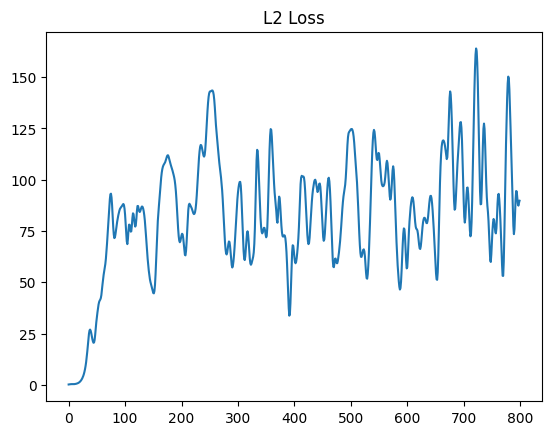

In [15]:
fig1, ax1 = plt.subplots()
ax1.set_title('L2 Loss')
ax1.plot(loss_traj)

* As it  can be seen from the figures above, both solutions follow a similar pattern during the beginning of the simulation but as time passes we can not see this behavior. We cannot blame the network for this patterns since **Residual Blocks** are used to prevent the drawbacks of the **deeper** CNNs. Thus, as it is the case in the Ex-7, supervised training does not ensure to reflect the nature of the problem itself